# Chemical Descriptors

### João Henrique Oliveira Fontes

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import DataStructs
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_selection import RFE
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoCV
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from mordred import Calculator, descriptors
import pandas as pd
import numpy as np
import json
import warnings; warnings.simplefilter('ignore')

In [2]:
train_sizes = [10, 100, 1000, 10000]
mae = []
pca_mae = []
rfc_mae = []

In [3]:
data_path = 'Downloads/qm9.json.gz'
data = pd.read_json(data_path, lines=True)
data['mol'] = data['smiles_0'].apply(Chem.MolFromSmiles)

In [4]:
calc = Calculator(descriptors, ignore_3D=True)
desc = calc.pandas(data['mol'])

100%|████████████████████████████████████████████████████████████████████████████| 25000/25000 [12:07<00:00, 34.35it/s]


In [6]:
desc = desc.astype('float64')
missing_values = desc.isnull().any()
desc = desc.loc[:, ~missing_values]

In [7]:
mol_train, mol_test, band_train, band_test = train_test_split(desc, data['bandgap'], test_size=2000, train_size=20000)

In [8]:
for s in train_sizes:
    lasso = LassoCV().fit(mol_train[:s], band_train[:s])
    y_pred = lasso.predict(mol_test)
    mae.append(mean_absolute_error(band_test, y_pred))

In [9]:
pca_model = Pipeline([
    ('pca', PCA(n_components=8)),
    ('lasso', LassoCV())
])

for s in train_sizes:
    y_pred = pca_model.fit(mol_train[:s], band_train[:s]).predict(mol_test)
    pca_mae.append(mean_absolute_error(band_test, y_pred))

In [10]:
for s in train_sizes:
    rfc = RandomForestRegressor().fit(mol_train[:s], band_train[:s])
    y_pred = rfc.predict(mol_test)
    rfc_mae.append(mean_absolute_error(band_test, y_pred))

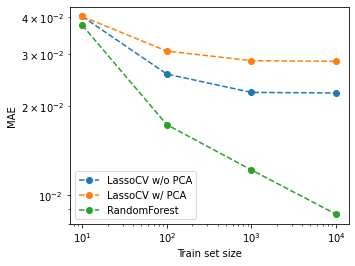

In [12]:
fig, ax = plt.subplots(figsize=(5,4))
ax.loglog(train_sizes, mae, '--o', label='LassoCV w/o PCA')
ax.loglog(train_sizes, pca_mae, '--o', label='LassoCV w/ PCA')
ax.loglog(train_sizes, rfc_mae, '--o', label='RandomForest')
ax.set_xlabel('Train set size')
ax.set_ylabel('MAE')
ax.legend()
plt.savefig('mae1.pdf')

How do the results compare? Why do some models continue to improve at large training set sizes while others do not?

A: The PCA reduces too much the variance of the training sample, that is, samples that are very different may be processed as being similar, so that a larger number of training samples will not add much new information for the model. Similarly, LassoCV selects the most important features, but since they are not being projected into smaller dimensional spaces, they keep all their original variance, so it gives better results than the model with PCA, but still, this feature selection makes it ineffective for larger training sets to be used. Finally, RandomForest regression is a non-linear, complex model, with several decision layers, so it may be better for a problem like this one, where not a single feature is exactly linearly related to the bandgap, and where more training samples may result into more precise decision mechanisms.  

In [13]:
lasso_maxarg = np.argsort(lasso.coef_)[-10:]
rfc_maxarg = np.argsort(rfc.feature_importances_)[-10:]
inter = np.intersect1d(lasso_maxarg, rfc_maxarg)
print(desc.columns[inter])

Index([], dtype='object')


Are any the same? Why is this expected?

A: None of them are the same. This is expected since LassoCV is a linear model, and RandomForest is a complex, multi-layered model, so the features that are closest to be linearly dependent on the band gap energy may be relevant for LassoCV, but may be of little importance in RandomForest.

In [14]:
lasso_corr = [np.corrcoef(data['bandgap'], desc.iloc[:,i].tolist())[0][1] for i in lasso_maxarg]
rfc_corr = [np.corrcoef(data['bandgap'], desc.iloc[:,i].tolist())[0][1] for i in rfc_maxarg]

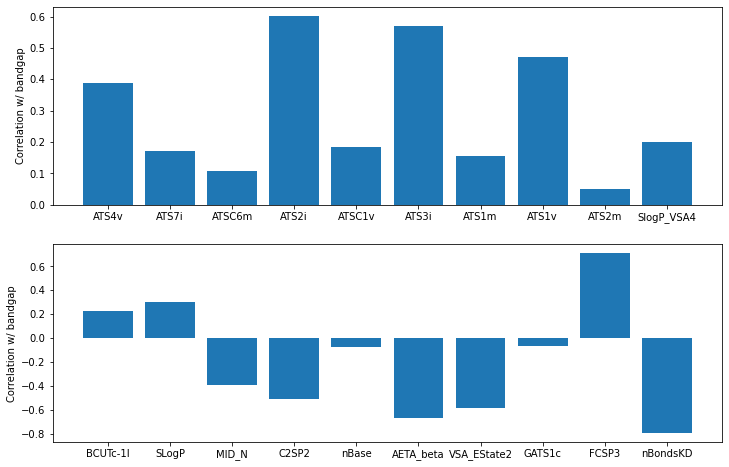

In [16]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,8))

ax1.bar(desc.columns[lasso_maxarg], lasso_corr)
ax1.set_ylabel('Correlation w/ bandgap')

ax2.bar(desc.columns[rfc_maxarg], rfc_corr)
ax2.set_ylabel('Correlation w/ bandgap')

plt.savefig('corr.pdf')

In [17]:
lasso2 = LassoCV().fit(mol_train[10000:], band_train[10000:])
lasso_maxarg2 = np.argsort(lasso2.coef_)[-10:]
lasso_corr2 = [np.corrcoef(data['bandgap'], desc.iloc[:,i].tolist())[0][1] for i in lasso_maxarg2]

 What does this imply about how to interpret the most important features?
 
 A: You cannot immediately interpret an important feature from a model to be representative of a physical characteristic of the material that actually plays a direct role in determining the test feature. That is, the importance of a feature may depend more on the model used than on the physical or chemical phenomena related to it.

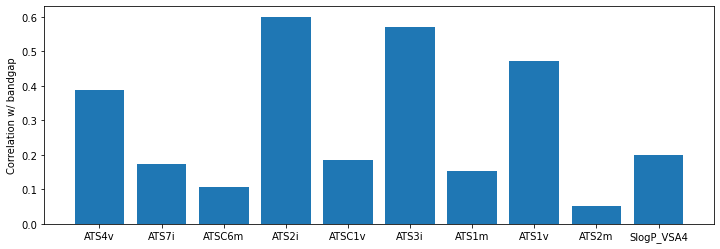

In [19]:
fig, ax1 = plt.subplots(figsize=(12,4))

ax1.bar(desc.columns[lasso_maxarg], lasso_corr)
ax1.set_ylabel('Correlation w/ bandgap')

plt.savefig('corr2.pdf')

Do the results change between runs?

A: No, since we were already dealing in the first place with a sufficiently large training set with a sufficiently large variance, the features observed in it must be to a large extent representative of the whole set of molecules.

Discuss the relative advantages of RandomForest versus Linear Regression versus Linear Regression with PCA.

A: In addition to what has been said above, PCA reduces by a significant amount the computational power needed to calculate the weights of the model, while RandomForest will be much more time-consuming, and if the model is too complex (too many decision layers), it will tend to overfit much more easily, which will hardly happen with linear regression models.

# Molecular Fingerprints

In [20]:
data = pd.read_json(data_path, lines=True).sample(3000)
mol_train, mol_test, band_train, band_test = train_test_split(data['smiles_0'], data['bandgap'], test_size=2000, train_size=1000)

In [21]:
def compute_morgan_fingerprints(smiles, fingerprint_length: int, fingerprint_radius: int):
    
    mol = Chem.MolFromSmiles(smiles)
    fingerprint = AllChem.GetMorganFingerprintAsBitVect(
        mol, fingerprint_radius, fingerprint_length)
    arr = np.zeros((1,), dtype=np.bool)
    DataStructs.ConvertToNumpyArray(fingerprint, arr)
    return arr

In [22]:
class MorganFingerprintTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self, length: int = 128, radius: int = 3):
        self.length = length
        self.radius = radius
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        fing = [compute_morgan_fingerprints(m, self.length, self.radius) for m in X]
        return np.vstack(fing)
m = MorganFingerprintTransformer(128, 3)

In [23]:
mol_train = m.transform(mol_train)
mol_test = m.transform(mol_test)

In [24]:
krr_mae=[]
dist=[]
for i in range(8):
    d=2**i
    dist.append(d)
    krr = KNeighborsRegressor(n_neighbors=d, metric='jaccard')
    y_pred = krr.fit(mol_train, band_train).predict(mol_test)
    krr_mae.append(mean_absolute_error(band_test, y_pred))

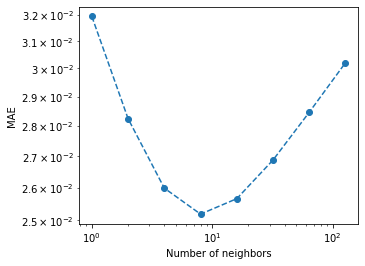

In [26]:
fig, ax = plt.subplots(figsize=(5,4))
ax.loglog(dist, krr_mae, '--o')
ax.set_xlabel('Number of neighbors')
ax.set_ylabel('MAE')
plt.savefig('krrmae.pdf')

Explain why the MAE improves when increasing from 1 and then worsens as you increase past $2^4$.

A: Because when we take into our calculation a number of neighbors that is too large, it will compare our test molecule to many other ones that may be quite different structuraly to it, especially if the molecules in our set are not large enough for the different fingerprints to be relevant measures of the similarities among them.

In [27]:
rf = RandomForestRegressor()
selector = RFE(estimator=rf, n_features_to_select=32, step=24)
selector.fit(mol_train, band_train)
rfe_train = selector.transform(mol_train)
rfe_test = selector.transform(mol_test)

In [28]:
rfe_mae=[]
dist=[]
for i in range(8):
    d=2**i
    dist.append(d)
    krr = KNeighborsRegressor(n_neighbors=d, metric='jaccard')
    y_pred = krr.fit(rfe_train, band_train).predict(rfe_test)
    rfe_mae.append(mean_absolute_error(band_test, y_pred))

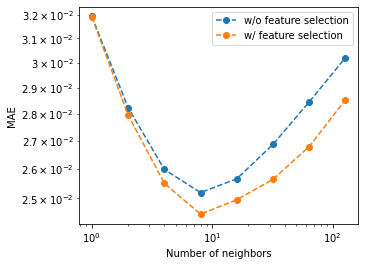

In [31]:
fig, ax = plt.subplots(figsize=(5,4))
ax.loglog(dist, krr_mae, '--o', label='w/o feature selection')
ax.loglog(dist, rfe_mae, '--o', label='w/ feature selection')
ax.set_xlabel('Number of neighbors')
ax.set_ylabel('MAE')
ax.legend()
plt.savefig('rfemae.pdf')

Why would the model with the feature selection perform better? In general terms, explain the disadvantage of using a general-purpose distance metrics such as fingerprints and how must one must account for that.

A: Since the size of the fingerprints are very large, it will have many features that do not account for the true similarities among the molecules, so feature selection will make the fingerprints more able to differentiate molecules, and consequently, will make the model more accurate as it will not be affected too much by features that are not actually descriptive. Fingerprints will not be too efficient if the molecules passed to the model vary too much in size, so that it will generate features that are not descriptive enough for some, while being too precise for others.